<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Practice Session - 07  </font></center></h1>
<h2><center> <font color='black'> Text Representation</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


# Already Covered:
1. **Get familiar with the graphs and how to work with them using igraph library; [Lab - 02]**
2. **Analyse the data about media companies. Figure out their connections; [Lab - 02]**
3. **Learn about various way of displaying statistic on the graphs; [Lab - 02]**
4. **Network models and descriptions using Networkx library; [Lab - 03]**

5. **Network Centrality Measures using networkx; [Lab - 04]**
6. **Network Communities using networkx/igraph [Lab - 05]**
7. **Link Prediction [Lab - 06]**

# Today's session agenda:
+ **Text Representation**
  1. Multi-tweet extractive summarization<br>
    1.1. Loading data<br>
    1.2. Pre-processing<br>
    1.3. Similarity calculation and graph creation<br>
    1.4. Summarization using LexRank<br>
  2. Signed Networks


## Loading and installing all required packages

In [ ]:
!pip install lexrank
!pip install sentence-transformers
!pip install sumy

In [ ]:
from IPython.display import Image
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import re
from sentence_transformers import SentenceTransformer, util
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import matplotlib.cm as cm
from collections import Counter
from nltk.tokenize import sent_tokenize

pd.options.mode.copy_on_write = True

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Multi-tweet extractive summarization
We will be doing extractive summarization over multiple tweets today. First we have to use graphs to find semantically related tweets and then we will use LexRank to create an extractive summary out of it. Lets remind us, whats the difference of extractive and abstractive summarization.

In [ ]:
Image(url="https://assets-global.website-files.com/62ab5c229babcf02f79fbd7d/63bd8a1f20da862484184fdb_blog%20extractive%20.png", height=400)

As can be seen from the figure above. Extractive summarization aim at extracting sentences from a given text and abstractive tries to summarize by generating completely new text. Now lets remind us what is semantic textual similarity.

In [ ]:
Image(url="https://miro.medium.com/v2/resize:fit:1200/1*sAJdxEsDjsPMioHyzlN3_A.png", height=500)

In our case we will be embedding mostly sentences, thus making sentence embeddings. We can calculate a semantic textual similarity between the texts using cosine similarity.

In [ ]:
Image(url="https://miro.medium.com/v2/resize:fit:915/1*dyH20eCqb6qTL-gt4nCVzQ.png", height=300)

In [ ]:
Image(url="https://miro.medium.com/v2/resize:fit:1400/0*GbzgZpzU-rW6Uls4", height=200)

In [ ]:
Image(url="https://2.bp.blogspot.com/-9Qk1fubLpzg/Wv2QGgKVVmI/AAAAAAAACvs/Gm-XF3prXVIIvaIkrTmkcIcYz-4qSxLKwCLcBGAs/s1600/image2.png", height=400)

Finally, we can get to solving the task

## 1.1. Loading and understanding data

First we have to load in a portion of the SemEval-2016 Stance Dataset.

In [ ]:
data = pd.read_csv('tweets.csv', header=None)

data.columns = [
    'tweet', 'category', 'stance']

data.head()

,tweet,category,stance
0,closed door session begins . more after they d...,climate change is a real concern,1
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2


Let us look at how many different stances we have in the dataset

Cheat sheet:

- 0 - against
- 1 - neutral
- 2 - supportive

In [ ]:
data["stance"].value_counts()

0    1945
1    1111
2    1081
Name: stance, dtype: int64

Let us look what different categories we have

In [ ]:
data["category"].value_counts()

hillary clinton                     984
feminist movement                   949
legalization of abortion            933
donald trump                        707
climate change is a real concern    564
Name: category, dtype: int64

We only want to look at the "climate change is a real concern" for this lab.

In [ ]:
data = data[data["category"]=="climate change is a real concern"]
data["category"].value_counts()

climate change is a real concern    564
Name: category, dtype: int64

Let us also inspect the length differences of these tweets - to verify we don't have any strange outliers.

In [ ]:
data['tweet_length'] = data['tweet'].apply(len)

print(f"Maximum article length: {data['tweet_length'].max()}")
print(f"Minimum article length: {data['tweet_length'].min()}")

Maximum article length: 153
Minimum article length: 39


Great! Now let us start with our next phase - preprocessing.

### 1.2. Preprocessing

1.2.1. Lowercasing

In [ ]:
tweets_with_uppercase = data[data['tweet'].apply(lambda x: any(c.isupper() for c in x))]
tweets_with_uppercase.head()

,tweet,category,stance,tweet_length


In [ ]:
# However this is how your would do it if it would be needed

data["processed_tweet"] = data["tweet"].apply(lambda x: x.lower())
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the # energiewende agenda ? why are th...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,@ climasphere stocker : fish catch potential c...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


1.2.2. Removing URLs

In [ ]:
tweets_with_urls = data[data['processed_tweet'].apply(lambda x: bool(re.search(r'http\S+|www\S+|https\S+', x)))]
tweets_with_urls.head()

,tweet,category,stance,tweet_length,processed_tweet


In [ ]:
# However this is how you would do it if it would be needed

data["processed_tweet"] = data["processed_tweet"].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the # energiewende agenda ? why are th...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,@ climasphere stocker : fish catch potential c...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


1.2.3. Removing usernames (identified with @)

In [ ]:
tweets_with_usernames = data[data['processed_tweet'].apply(lambda x: bool(re.search(r'@\s*\w+', x)))]
tweets_with_usernames.head()

,tweet,category,stance,tweet_length,processed_tweet
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,@ climasphere stocker : fish catch potential c...
5,@ climasphere bony : extreme weather events ( ...,climate change is a real concern,2,139,@ climasphere bony : extreme weather events ( ...
10,interesting speaker maarten van aalst @ federa...,climate change is a real concern,2,129,interesting speaker maarten van aalst @ federa...
14,@ soundofideas we have to talk about new norma...,climate change is a real concern,1,56,@ soundofideas we have to talk about new norma...
19,"@ loic yes , you should n't . but , stop killi...",climate change is a real concern,1,132,"@ loic yes , you should n't . but , stop killi..."


In [ ]:
data["processed_tweet"] = data["processed_tweet"].apply(lambda x: re.sub(r'@\s*\w+', '', x))
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the # energiewende agenda ? why are th...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop by ...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


1.2.4. hashtag removal (only symbol)

In [ ]:
tweets_with_hashtags = data[data['processed_tweet'].apply(lambda x: bool(re.search(r'#', x)))]
tweets_with_hashtags.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the # energiewende agenda ? why are th...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop by ...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


In [ ]:
data["processed_tweet"] = data["processed_tweet"].apply(lambda x: re.sub(r'#', '', x))
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the energiewende agenda ? why are the...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop by ...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


1.2.5. extra space removal

In [ ]:
tweets_with_spaces = data[data['processed_tweet'].apply(lambda x: bool(re.search(r'\s+', x)))]
tweets_with_spaces

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the energiewende agenda ? why are the...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop by ...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...
...,...,...,...,...,...
559,if sea levels get any higher flooding in lowla...,climate change is a real concern,2,77,if sea levels get any higher flooding in lowla...
560,if we do n't do anything we will be the sad ge...,climate change is a real concern,2,129,if we do n't do anything we will be the sad ge...
561,vallaud-belkacem : are we the generation who k...,climate change is a real concern,2,124,vallaud-belkacem : are we the generation who k...
562,"if we do not act , we will be the generation w...",climate change is a real concern,2,103,"if we do not act , we will be the generation w..."


In [ ]:
data["processed_tweet"] = data["processed_tweet"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . more after they d...
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,what is the energiewende agenda ? why are they...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop by a...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... a longer memory , and a sterner sense of j..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise will not be unif...


1.2.6. tokenize and remove stopwords

In [ ]:
data["processed_tweet"] = data["processed_tweet"].apply(lambda x: word_tokenize(x))
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,"[closed, door, session, begins, ., more, after..."
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,"[what, is, the, energiewende, agenda, ?, why, ..."
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,"[stocker, :, fish, catch, potential, could, dr..."
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"[..., a, longer, memory, ,, and, a, sterner, s..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,"[boni, ``, future, sea, level, rise, will, not..."


In [ ]:
data["processed_tweet"] = data["processed_tweet"].apply(lambda tokens: [word for word in tokens if word not in stopwords.words('english')])

data["processed_tweet"] = data["processed_tweet"].apply(lambda x: ' '.join(x))

data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . decide entities ....
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,energiewende agenda ? `` de-carbonizer `` camp...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop much...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... longer memory , sterner sense justice . -w..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise uniform & differ...


## 1.3. Similarity calculation and graph creation

1.3.1. Let us use Sentence Transformers to create contextual embeddings out of our processed tweets.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Let us now calculate the embeddings

In [ ]:
embeddings = np.array(model.encode(data['processed_tweet'].tolist()))

1.3.2. Calculating cosine similarity between text embeddings.

In [ ]:
cosine_sim_matrix = util.cos_sim(embeddings, embeddings)

1.3.3. Let us now build a graph where nodes are our tweets and edges are the similarity between them. We will only consider edges that are over our given threshold of 0.7. This threshold is not universal and usually depends on your data.

In [ ]:
G = nx.Graph()

threshold = 0.7

for i in range(cosine_sim_matrix.shape[0]):
    for j in range(i + 1, cosine_sim_matrix.shape[1]):
        if i not in G:
            G.add_node(i, text=data.loc[i, 'tweet'])
        if j not in G:
            G.add_node(j, text=data.loc[j, 'tweet'])
        if cosine_sim_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=float(cosine_sim_matrix[i, j]))

1.3.4. Let us visualize our graph

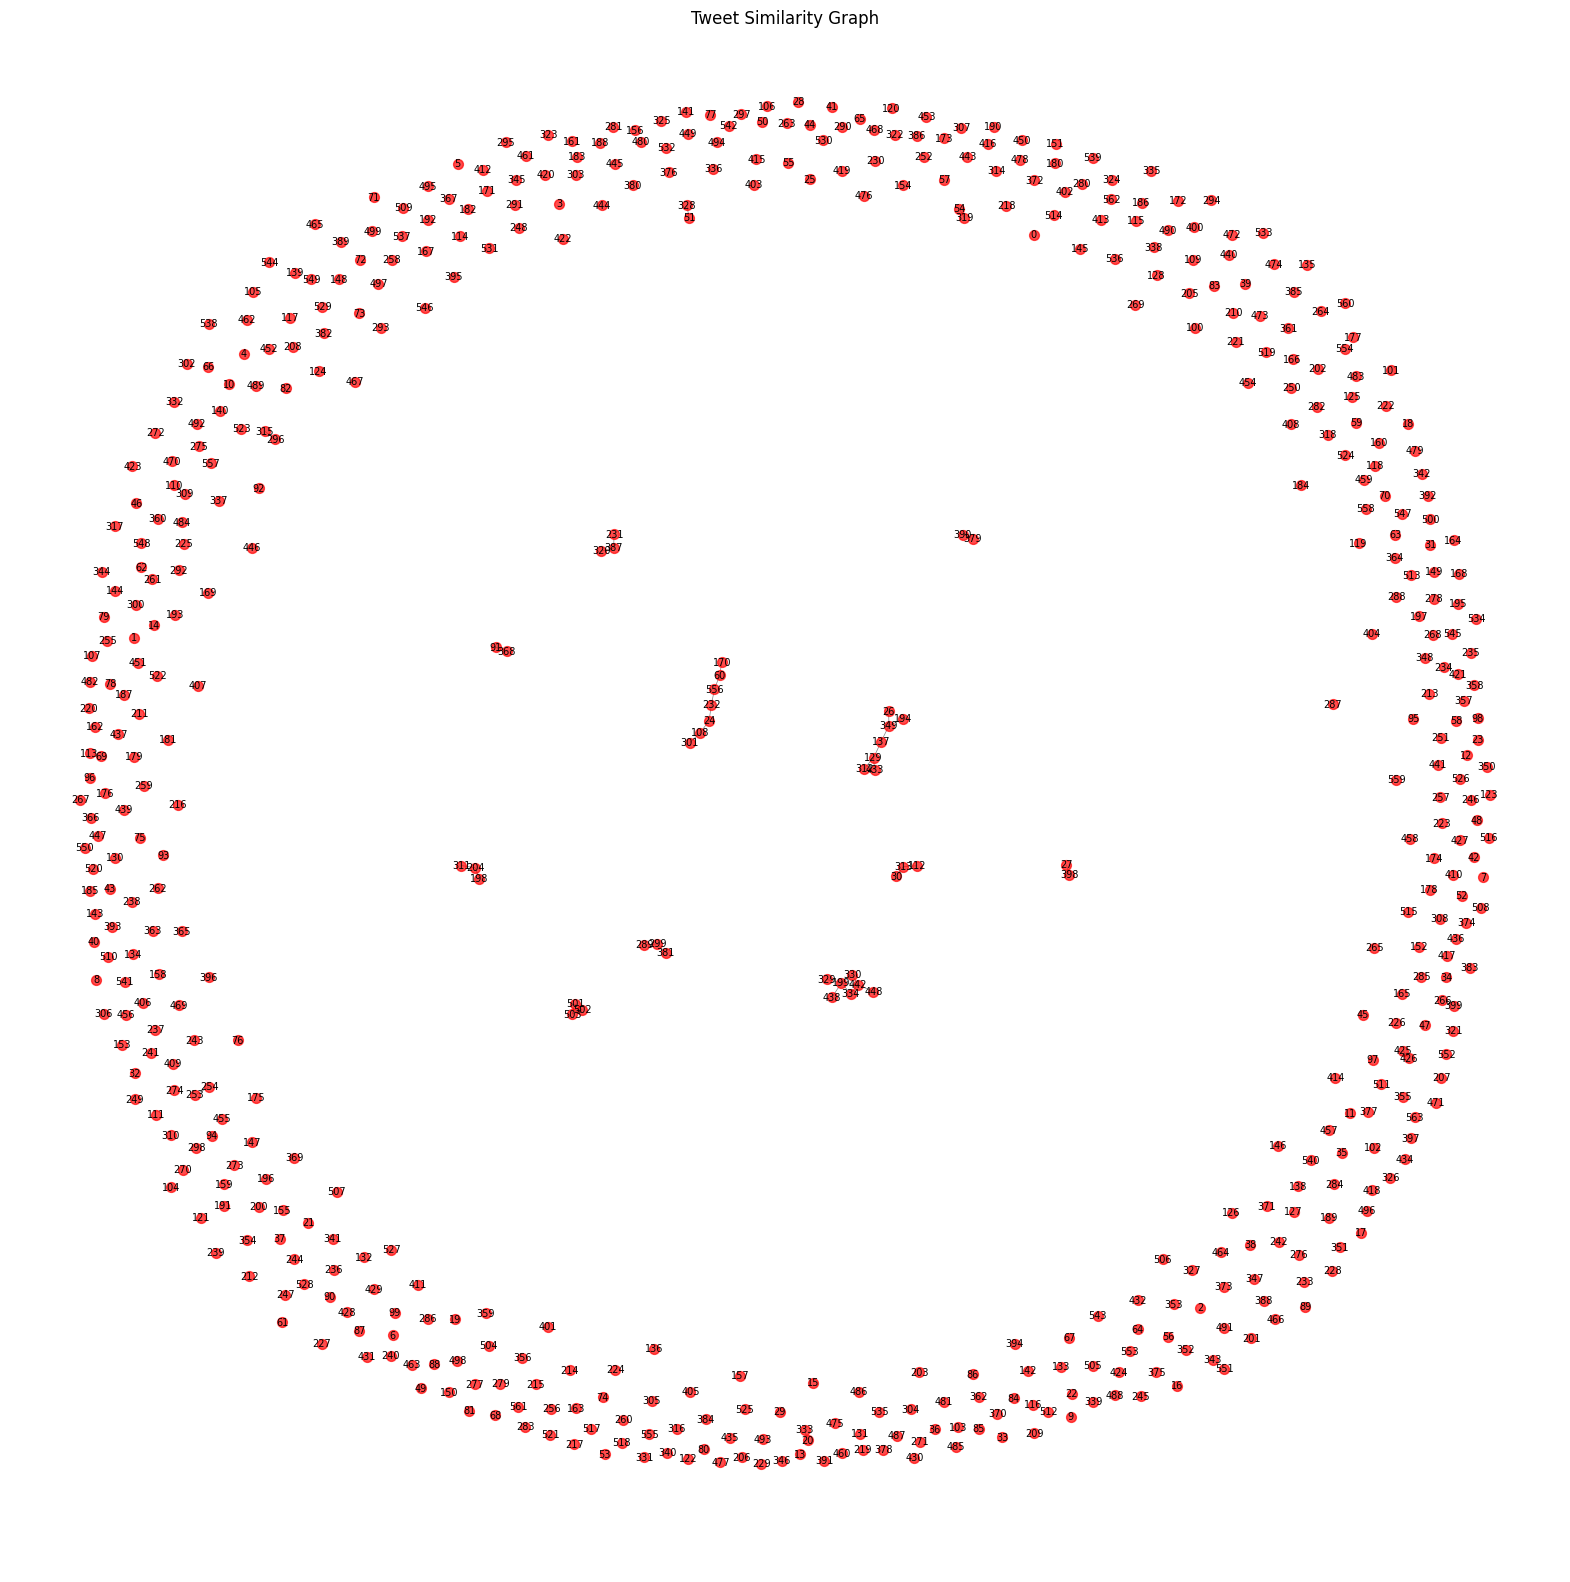

In [ ]:
plt.figure(figsize=(20, 20))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='red', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=7)

nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color="black")

plt.title('Tweet Similarity Graph')
plt.axis('off')
plt.show()

1.3.5. Let us identify the five largest connected networks

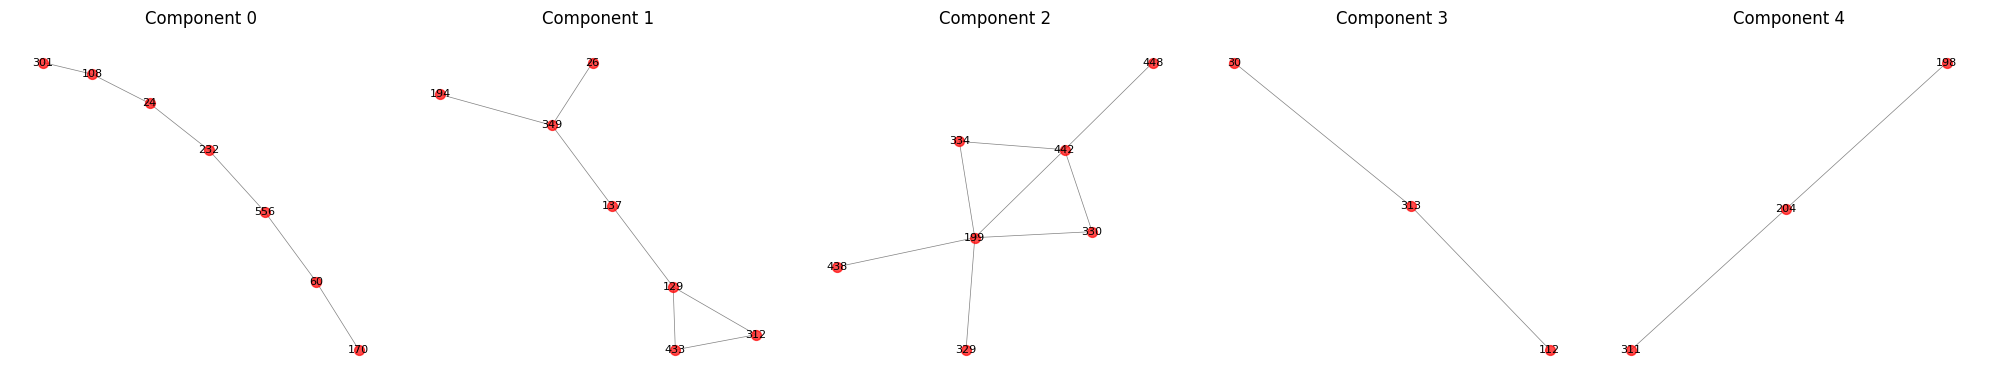

In [ ]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

largest_components = [G.subgraph(c).copy() for c in connected_components[:5]]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, component in enumerate(largest_components):
    pos = nx.spring_layout(component)
    nx.draw_networkx_nodes(component, pos, node_size=50, node_color='red', alpha=0.7, ax=axes[i])
    nx.draw_networkx_edges(component, pos, width=0.5, alpha=0.5, edge_color="black", ax=axes[i])
    nx.draw_networkx_labels(component, pos, font_size=8, ax=axes[i])
    axes[i].set_title(f'Component {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Let us see if the tweets within one component are actually similar or just false positives. For this let us print out all of the tweets for component 0.

In [ ]:
zeroth_largest_component = connected_components[0]

for node_id in zeroth_largest_component:
    tweet_text = data.loc[node_id, 'tweet']
    print(tweet_text)

( 2/2 ) 300 words and be sent to climateconference2015 @ gmail.com # sustainability # sustainabledevelopment # semst
rt @ cderworiz : timelines are short . strategy must be in place by climate change conference in paris by december . # ableg # semst
@ un_spokesperson @ france24 @ un @ cop21 @ norwaymfa `` we are the last generation who can address this climate change # semst
a changing planet : 4 places where climate change is taking its toll # semst
. @ climatparis2015 , the climate science forum begins today . follow its progress on # cfcc15 # sustainabledevelopment # semst
we can address both climate change and sustainable development with the same measures @ cfigueres # sdgs # climateaction # cop21 # semst
follow @ climatparis2015 for information on # cfcc15 - the climate change conference in paris . # semst


Let us look at another connected network like the first one.

In [ ]:
first_largest_component = connected_components[1]

for node_id in first_largest_component:
    tweet_text = data.loc[node_id, 'tweet']
    print(tweet_text)

# mission : # climate on the road > fly less # tip # earthrightnow # semst
# mission : # climate @ home > buy drinking water & soda in big bottles ... # tip # semst
# mission : # climate on the road > purchase a fuel-efficient , low-greenhouse gas vehicle ( by @ epa ) # tip # missionaccept # semst
# mission : # climate on the road > drive less ( by @ greengoddess892 ) # tip # impactisreal # semst
# mission : # climate on the road > give your car a break ( by @ epa ) # tip # semst
# mission : # climate @ home > purchase renewable power from your utility ( by @ avekathleen ) # tip # impactisreal # semst
# mission : # climate @ home > purchase green power ( if available ) ( by @ epa ) # tip # semst


This is not the biggest dataset. But in real life social media data, it will be more difficult to identify communities by eye as there are more similar tweets. Thus it is useful to also do some community detection. Let us now implement on the same graph louvain community detection.

<ipython-input-41-96b7e83dd4c6>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


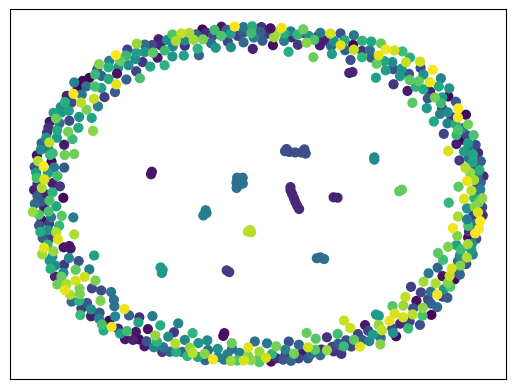

In [ ]:
partition = community_louvain.best_partition(G)

pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## 1.4. Summarizing using LexRank

Great! Now let us also identify the 3rd largest community and use that to do multi-tweet summarization



In [ ]:
community_sizes = Counter(partition.values())

sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

third_largest_community_id, _ = sorted_communities[2]

third_largest_community_nodes = [node for node, community_id in partition.items() if community_id == third_largest_community_id]

print(f"3rd Largest Community ID: {third_largest_community_id}")
print(f"Number of Nodes in 3rd Largest Community: {len(third_largest_community_nodes)}")
print("Nodes in 3rd Largest Community:", third_largest_community_nodes)

3rd Largest Community ID: 194
Number of Nodes in 3rd Largest Community: 7
Nodes in 3rd Largest Community: [199, 329, 330, 334, 438, 442, 448]


Now lets take the tweets corresponding to the node ids and split the text into sentences.

In [ ]:
tweets_third_community = data.loc[third_largest_community_nodes]['tweet']

all_sentences = []

for tweet in tweets_third_community:
    sentences = sent_tokenize(tweet)
    all_sentences.extend(sentences)

print("Number of sentences:", len(all_sentences))
print("Some example sentences:", all_sentences[:10])

Number of sentences: 9
Some example sentences: ["ca n't wait to watch 'when attenborough met obama ' should be fascinating !", '@ potus # sirdavidattenborough # lovemydavid # hero # semst', "barack obama meets david attenborough , i 'm so ready for this and i can not wait !", "89 year 's old and always on form # legend # semst", 'enjoying watching sir david attenborough and obama talk about climate change mitigation # lovenature # semst', 'amazing interview with @ potus and david attenborough # semst', 'australia ... your turn to watch obama & attenborough @ abcenvironment # semst', 'david attenborough being interviewed by president obama is brilliant & fascinating viewing # foreigncorrespondent # abc # tunein # semst', "obama & attenborough brilliant , heart felt & honest why ca n't we have such a discussion here in oz # renewables # abc # auspol # semst"]


Now let us use LexRank to summarize the tweets into one extractive summary

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

text = " ".join(all_sentences)

parser = PlaintextParser.from_string(text, Tokenizer("english"))

summarizer = LexRankSummarizer()

summary_sentences = summarizer(parser.document, sentences_count=3)

summary = [str(sentence) for sentence in summary_sentences]

summary_text = " ".join(summary)

print("Summary:")
print(summary_text)

Summary:
ca n't wait to watch 'when attenborough met obama ' should be fascinating ! @ potus # sirdavidattenborough # lovemydavid # hero # semst barack obama meets david attenborough , i 'm so ready for this and i can not wait ! 89 year 's old and always on form # legend # semst enjoying watching sir david attenborough and obama talk about climate change mitigation # lovenature # semst amazing interview with @ potus and david attenborough # semst australia ... your turn to watch obama & attenborough @ abcenvironment # semst david attenborough being interviewed by president obama is brilliant & fascinating viewing # foreigncorrespondent # abc # tunein # semst obama & attenborough brilliant , heart felt & honest why ca n't we have such a discussion here in oz # renewables # abc # auspol # semst


Lets display the text and hashtags separately

In [ ]:
hashtags = re.findall(r"# \w+", str(summary))
hashtags = [hashtag.replace(" ","") for hashtag in hashtags]
text_without_hashtags = re.sub(r"\s?# \w+", "", str(summary))

print("Extracted hashtags:", hashtags)
print("Text without hashtags:", text_without_hashtags)

Extracted hashtags: ['#sirdavidattenborough', '#lovemydavid', '#hero', '#semst', '#legend', '#semst', '#lovenature', '#semst', '#semst', '#semst', '#foreigncorrespondent', '#abc', '#tunein', '#semst', '#renewables', '#abc', '#auspol', '#semst']
Text without hashtags: ["ca n't wait to watch 'when attenborough met obama ' should be fascinating !", "@ potus barack obama meets david attenborough , i 'm so ready for this and i can not wait !", "89 year 's old and always on form enjoying watching sir david attenborough and obama talk about climate change mitigation amazing interview with @ potus and david attenborough australia ... your turn to watch obama & attenborough @ abcenvironment david attenborough being interviewed by president obama is brilliant & fascinating viewing obama & attenborough brilliant , heart felt & honest why ca n't we have such a discussion here in oz"]


While this summary is not the best in terms of style, as might be the case with extractive summarization methods. It nevertheless gives us a good understanding of one discussion topic within this climate category

# 2. Signed networks

In [ ]:
Image(url="https://www.researchgate.net/publication/264247590/figure/fig8/AS:341315700183048@1458387412591/Examples-of-unsigned-and-signed-social-network-graph.png", height=300)

Signed networks have several use-cases:
- Opinion mining (i.e. determining sentiment on certain topics)
- Trust networks (i.e. AirBnB or Bolt user ratings)
- Recommendation systems (i.e. users who rate similarly similar products get recommended products for which they gave higher ratings)
- Fraud detection (identifying negative connections can highlight malicious users)

Today however, we will only do a simple visualization of signed networks in this lab.

In [ ]:
Image(url="https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41598-017-11463-y/MediaObjects/41598_2017_11463_Fig1_HTML.jpg", height=300)

Let us once again look at our dataset

In [ ]:
data.head()

,tweet,category,stance,tweet_length,processed_tweet
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . decide entities ....
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,energiewende agenda ? `` de-carbonizer `` camp...
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop much...
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... longer memory , sterner sense justice . -w..."
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise uniform & differ...


Let us map the stance to a range of [+1,0,-1]

In [ ]:
data['stance_mapped'] = data['stance'].map({2: 1, 0: -1, 1: 0})
data.head()

,tweet,category,stance,tweet_length,processed_tweet,stance_mapped
0,closed door session begins . more after they d...,climate change is a real concern,1,83,closed door session begins . decide entities ....,0
1,what is the # energiewende agenda ? why are th...,climate change is a real concern,2,134,energiewende agenda ? `` de-carbonizer `` camp...,1
2,@ climasphere stocker : fish catch potential c...,climate change is a real concern,2,135,stocker : fish catch potential could drop much...,1
3,"... a longer memory , and a sterner sense of j...",climate change is a real concern,1,82,"... longer memory , sterner sense justice . -w...",0
4,boni `` future sea level rise will not be unif...,climate change is a real concern,2,106,boni `` future sea level rise uniform & differ...,1


In [ ]:
data["stance_mapped"].value_counts()

 1    335
 0    203
-1     26
Name: stance_mapped, dtype: int64

Lets downsample each stance so that we have an equal amount of stances.

In [ ]:
min_count = data['stance_mapped'].value_counts().min()

data = data.groupby('stance_mapped').sample(n=min_count, random_state=1)

data['stance_mapped'].value_counts()

-1    26
 0    26
 1    26
Name: stance_mapped, dtype: int64

Now we can create a signed network. We add all tweets as nodes and then between each pair of nodes we see if they have a stance different from 0. If they have the same stance, then we add a green edge, if the tweets have a different stance, then we add a red line.

In [ ]:
data.reset_index(drop=True, inplace=True)

G_signed = nx.Graph()

for index, row in data.iterrows():
    G_signed.add_node(index, tweet=row['tweet'], stance=row['stance_mapped'])

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if data.loc[i, 'stance_mapped'] != 0 and data.loc[j, 'stance_mapped'] != 0:
            G_signed.add_edge(i, j, weight=data.loc[i, 'stance_mapped'] * data.loc[j, 'stance_mapped'])

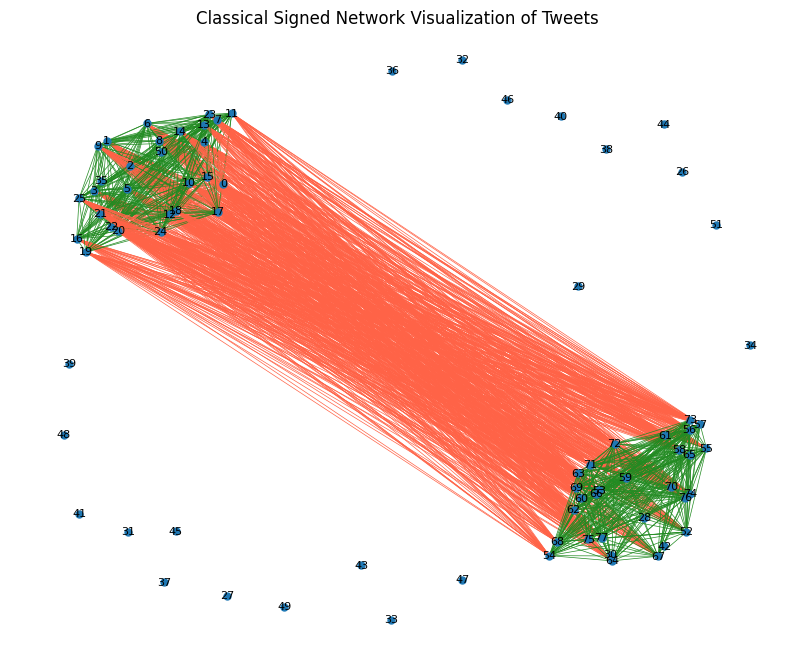

In [ ]:
plt.figure(figsize=(10, 8))

pos_signed = nx.spring_layout(G_signed)

nx.draw_networkx_nodes(G_signed, pos_signed, node_size=25)

edge_colors = ['forestgreen' if data['weight'] > 0 else 'tomato' for _, _, data in G_signed.edges(data=True)]
nx.draw_networkx_edges(G_signed, pos_signed, width=0.5, edge_color=edge_colors)

nx.draw_networkx_labels(G_signed, pos_signed, font_size=8)

plt.title("Classical Signed Network Visualization of Tweets")
plt.axis('off')
plt.show()

#Here you go, enjoy solving your homework!